In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.signal
import os
import time
import data.data_util as data_util

In [2]:
eeg = data_util.load_data('data/JN_movement_w_feedback_1/eeg.bin')
task = data_util.load_data('data/JN_movement_w_feedback_1/task.bin')
print('databuffer shape:', eeg['databuffer'].shape)
print('length of experiment (minutes):', eeg['databuffer'].shape[0]/1000/60)
eeg['databuffer'] = eeg['databuffer'][:, 0:64]

databuffer shape: (938837, 66)
length of experiment (minutes): 15.647283333333332


In [3]:
keep = np.ones(64, dtype='bool')
D = np.sum(keep)

adjacency = data_util.adjacency[keep, :][:, keep]
laplacian = np.eye(D) - (adjacency/np.maximum(np.sum(adjacency, axis=1), 1)).T
next_adjacency = data_util.next_adjacency[keep, :][:, keep]
laplacian_next = np.eye(D) - (next_adjacency/np.maximum(np.sum(next_adjacency, axis=1), 1)).T

eeg['databuffer'] = eeg['databuffer'][:, keep]
electrode_names = [data_util.electrode_names[i] for i in range(len(keep)) if keep[i]]

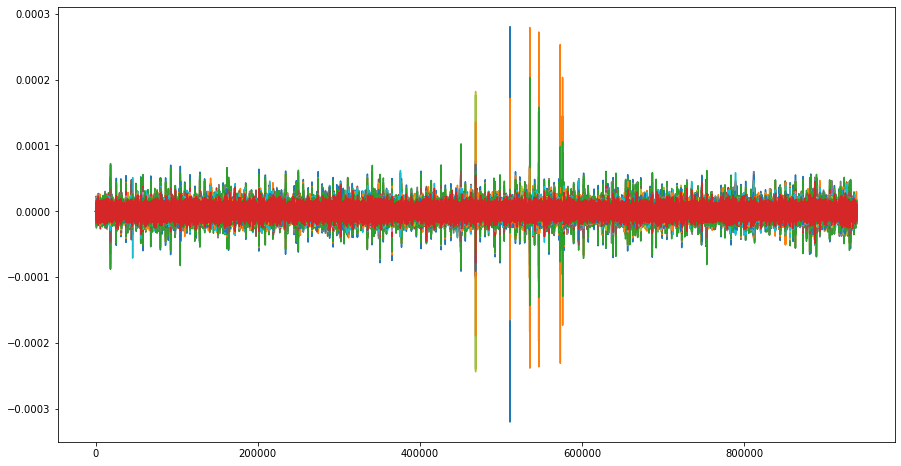

In [4]:
plt.figure(figsize=(15, 8))
_ = plt.plot(eeg['databuffer'])

In [5]:
Fc = 4.0 # lower cutoff frequency in Hz
sosHP = scipy.signal.butter(4, Fc/1000.0*2.0, btype='highpass', output='sos')
zi0 = scipy.signal.sosfilt_zi(sosHP)
zi = zi0[:, :, None]@eeg['databuffer'][None, 0, :]
data, zo = scipy.signal.sosfilt(sosHP, eeg['databuffer'][::, :], axis=0, zi=zi)
# data: band-passed filtered data

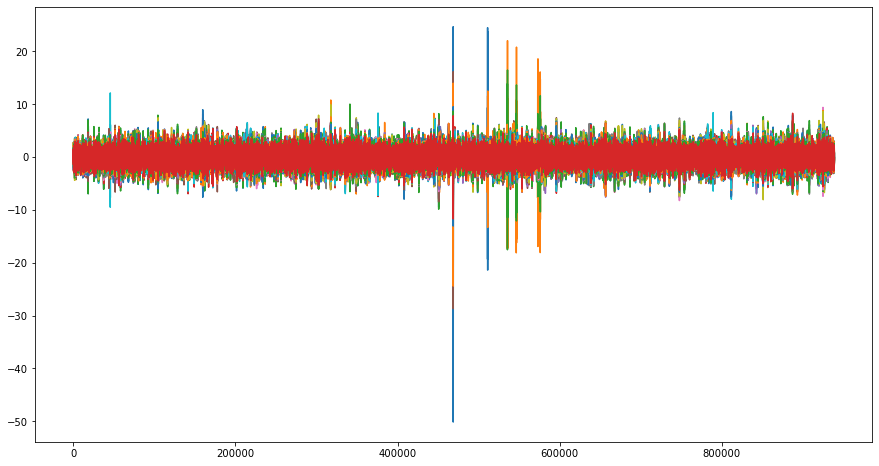

In [6]:
plt.figure(figsize=(15, 8))
_ = plt.plot(data/np.std(data, axis=0))

In [7]:
data_lap = data@laplacian.T # nearest neighbors laplacian filtering. optional: scale by std
data_lapnext = data@laplacian_next.T # next nearest neighbors laplacian filtering

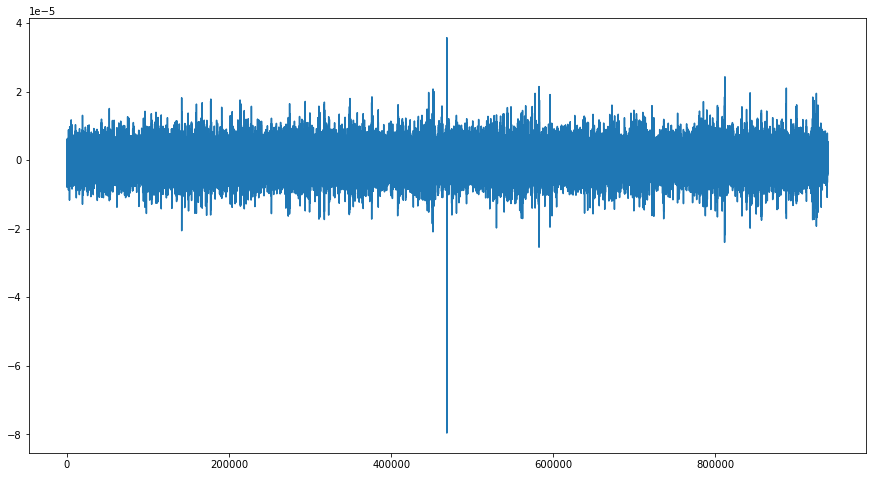

In [8]:
plt.figure(figsize=(15, 8))
_ = plt.plot(data[:, electrode_names.index('C3')])

In [9]:
has_art = (data[:, electrode_names.index('C3')] > 0.00002)

In [10]:
new_state_bool = np.zeros(task['state_task'].size, dtype='bool')
new_state_bool[1:] = (task['state_task'][1:] != task['state_task'][:-1])
new_state_inds = np.nonzero(new_state_bool)[0]
new_state_states = task['state_task'][new_state_inds]

tmp = new_state_inds.size
trial_slices = new_state_inds[1:2*(tmp//2)-1].reshape((-1, 2))

trial_eeg_slices = np.zeros_like(trial_slices)
trial_eeg_slices[:, 0] = task['eeg_step'][trial_slices[:, 0]] + 1
trial_eeg_slices[:, 1] = task['eeg_step'][trial_slices[:, 1]-1]

trial_eeg_slices = trial_eeg_slices[2:len(trial_slices)-2]
trial_slices = trial_slices[2:len(trial_slices)-2]

trial_keep = np.array([(np.sum(has_art[inds[0]:inds[1]]) == 0) for inds in trial_eeg_slices])
trial_eeg_slices = trial_eeg_slices[trial_keep]
trial_slices = trial_slices[trial_keep]
print(trial_slices.shape)

(147, 2)


In [11]:
y = task['state_task'][trial_slices[:, 0]]
print(y.shape)

(147,)


# End data preprocessing

In [12]:
plt.rcParams.update({'font.size': 16})


In [13]:
L = 4000


In [14]:
# data_lapnext: next nearest neighbors laplacian
c3 = data_lapnext[:, electrode_names.index('C3')]
c4 = data_lapnext[:, electrode_names.index('C4')]
#c3 = data3[:, electrode_names.index('C3')]
#c4 = data3[:, electrode_names.index('C4')]
#c3 /= np.std(c3)
#c4 /= np.std(c4

In [15]:
c3_spec = data_util.sliding_dft(c3.reshape((-1, 1)), 1000, 30).squeeze()
c4_spec = data_util.sliding_dft(c4.reshape((-1, 1)), 1000, 30).squeeze()

In [16]:
X_c3_spec = np.array([c3_spec[ind:ind+L] for ind in trial_eeg_slices[:, 0]]).squeeze()
X_c4_spec = np.array([c4_spec[ind:ind+L] for ind in trial_eeg_slices[:, 0]]).squeeze()

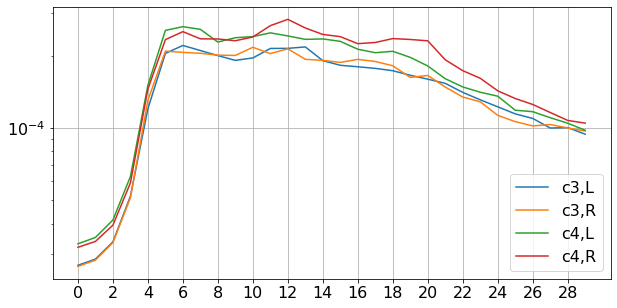

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(np.mean(np.abs(X_c3_spec[y == 0])[:, 1000:4000, :], axis=(0, 1)))
plt.plot(np.mean(np.abs(X_c3_spec[y == 1])[:, 1000:4000, :], axis=(0, 1)))
plt.plot(np.mean(np.abs(X_c4_spec[y == 0])[:, 1000:4000, :], axis=(0, 1)))
plt.plot(np.mean(np.abs(X_c4_spec[y == 1])[:, 1000:4000, :], axis=(0, 1)))
plt.legend(['c3,L', 'c3,R', 'c4,L', 'c4,R'])
plt.yscale('log')
_ = plt.xticks(np.arange(0, 30, 2))
plt.grid()

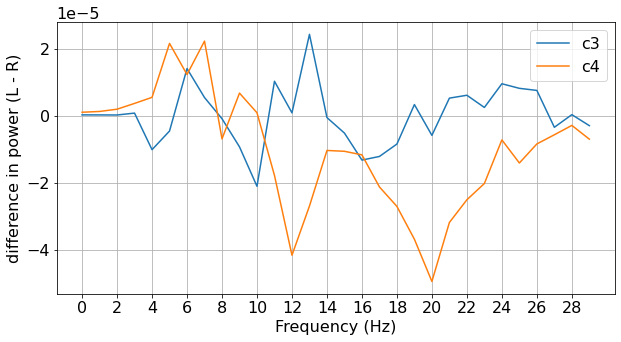

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(np.mean(np.abs(X_c3_spec[y == 0])[:, 1000:4000, :], axis=(0, 1)) - \
         np.mean(np.abs(X_c3_spec[y == 1])[:, 1000:4000, :], axis=(0, 1)))
plt.plot(np.mean(np.abs(X_c4_spec[y == 0])[:, 1000:4000, :], axis=(0, 1)) - \
         np.mean(np.abs(X_c4_spec[y == 1])[:, 1000:4000, :], axis=(0, 1)))
_ = plt.xticks(np.arange(0, 30, 2))
plt.grid()
plt.xlabel('Frequency (Hz)')
plt.ylabel('difference in power (L - R)')
plt.legend(['c3', 'c4'])

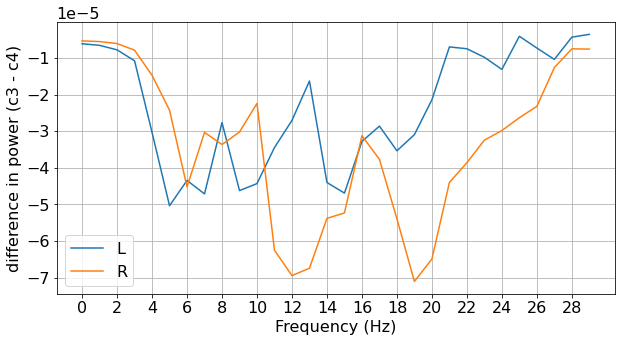

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(np.mean(np.abs(X_c3_spec[y == 0])[:, 1000:4000, :], axis=(0, 1)) - \
         np.mean(np.abs(X_c4_spec[y == 0])[:, 1000:4000, :], axis=(0, 1)))
plt.plot(np.mean(np.abs(X_c3_spec[y == 1])[:, 1000:4000, :], axis=(0, 1)) - \
         np.mean(np.abs(X_c4_spec[y == 1])[:, 1000:4000, :], axis=(0, 1)))
_ = plt.xticks(np.arange(0, 30, 2))
plt.grid()
plt.xlabel('Frequency (Hz)')
plt.ylabel('difference in power (c3 - c4)')
plt.legend(['L', 'R'])

Text(0.5, 0, 'time (ms)')

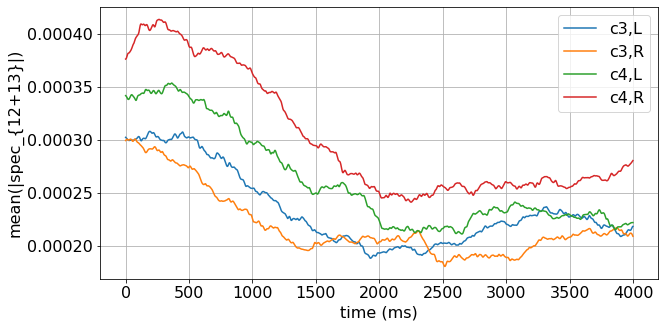

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(np.mean(np.abs(X_c3_spec[y == 0])[:, 0:4000, 12:14], axis=(0, 2)))
plt.plot(np.mean(np.abs(X_c3_spec[y == 1])[:, 0:4000, 12:14], axis=(0, 2)))
plt.plot(np.mean(np.abs(X_c4_spec[y == 0])[:, 0:4000, 12:14], axis=(0, 2)))
plt.plot(np.mean(np.abs(X_c4_spec[y == 1])[:, 0:4000, 12:14], axis=(0, 2)))
plt.legend(['c3,L', 'c3,R', 'c4,L', 'c4,R'])
plt.grid()
plt.ylabel('mean(|spec_{12+13}|)')
plt.xlabel('time (ms)')

Text(0.5, 0, 'time (ms)')

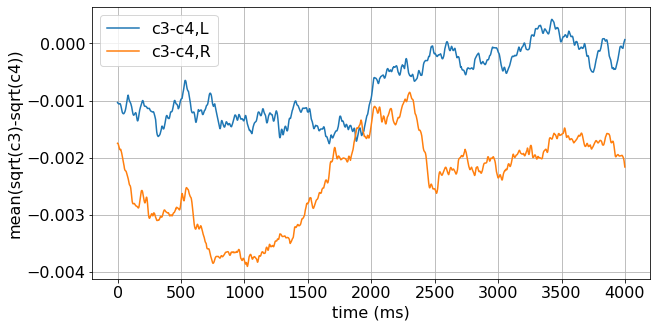

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(np.mean(np.sqrt(np.abs(X_c3_spec[y==0, :, 12:14])) - np.sqrt(np.abs(X_c4_spec[y==0, :, 12:14])), axis=(0, 2)))
plt.plot(np.mean(np.sqrt(np.abs(X_c3_spec[y==1, :, 12:14])) - np.sqrt(np.abs(X_c4_spec[y==1, :, 12:14])), axis=(0, 2)))
plt.legend(['c3-c4,L', 'c3-c4,R'])
plt.grid()
plt.ylabel('mean(sqrt(c3)-sqrt(c4))')
plt.xlabel('time (ms)')

In [22]:
f0 = np.mean(np.sqrt(np.abs(X_c3_spec[y == 0])[:, 0:4000, :]), axis=0) - \
         np.mean(np.sqrt(np.abs(X_c4_spec[y == 0])[:, 0:4000, :]), axis=0)
f1 = np.mean(np.sqrt(np.abs(X_c3_spec[y == 1])[:, 0:4000, :]), axis=0) - \
         np.mean(np.sqrt(np.abs(X_c4_spec[y == 1])[:, 0:4000, :]), axis=0)

Text(0, 0.5, 'frequency (Hz)')

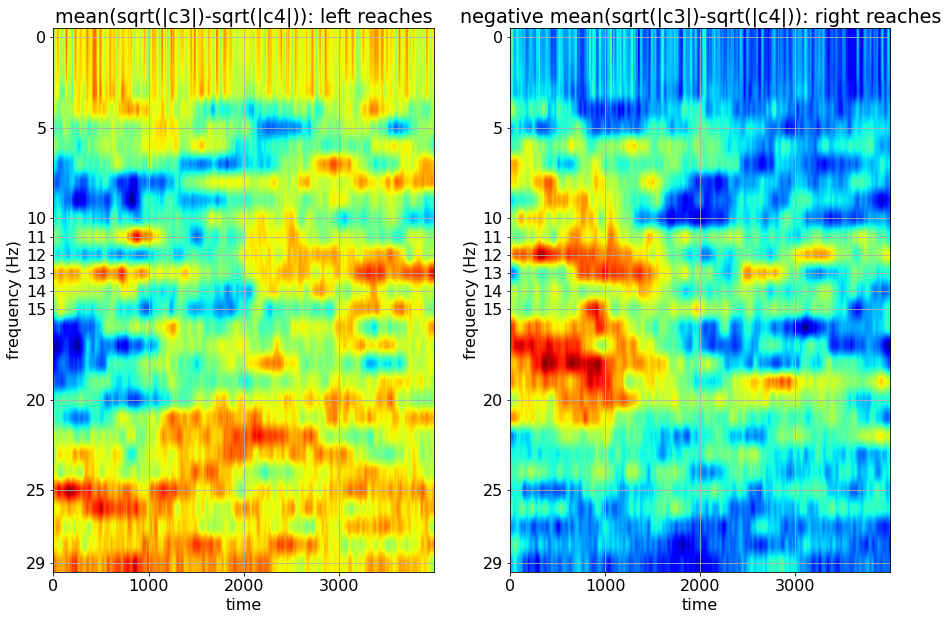

In [23]:
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.imshow(f0.T, aspect='auto', cmap='jet')
plt.yticks([0, 5, 10, 11, 12, 13, 14, 15, 20, 25, 29])
plt.grid()
plt.title('mean(sqrt(|c3|)-sqrt(|c4|)): left reaches')
plt.xlabel('time')
plt.ylabel('frequency (Hz)')
plt.subplot(1, 2, 2)
plt.imshow(-f1.T, aspect='auto', cmap='jet')
_ = plt.yticks([0, 5, 10, 11, 12, 13, 14, 15, 20, 25, 29])
plt.grid()
plt.title('negative mean(sqrt(|c3|)-sqrt(|c4|)): right reaches')
plt.xlabel('time')
plt.ylabel('frequency (Hz)')

In [24]:
N = y.size
nTrain = 100
train_inds = np.arange(nTrain)
test_inds = np.arange(nTrain, N)

In [25]:
psd_feature = np.sqrt(np.abs(X_c3_spec)[:, 0:4000, :]) - \
         np.sqrt(np.abs(X_c4_spec)[:, 0:4000, :])

In [26]:
thresholds = np.linspace(np.min(psd_feature), np.max(psd_feature), 101)
ROC = np.zeros((len(thresholds), 2, psd_feature.shape[1], psd_feature.shape[2]))

for i, threshold in enumerate(thresholds):
    ROC[i, 0] = np.mean(psd_feature[train_inds][y[train_inds]==0] < threshold, axis=0)
    ROC[i, 1] = np.mean(psd_feature[train_inds][y[train_inds]==1] < threshold, axis=0)
    #ROC[i, 0] = np.mean(psd_feature[...][y[...]==0] < threshold, axis=0)
    #ROC[i, 1] = np.mean(psd_feature[...][y[...]==1] < threshold, axis=0)
ACCS = 0.5*((1-ROC[:, 0, :, :]) + ROC[:, 1, :, :])
# ACCS.shape should be (len(thresholds), L, 30)

In [27]:
best_indices = np.unravel_index(np.argmax(ACCS), ACCS.shape)
np.max(ACCS), best_indices

(0.7252525252525253, (66, 3265, 12))

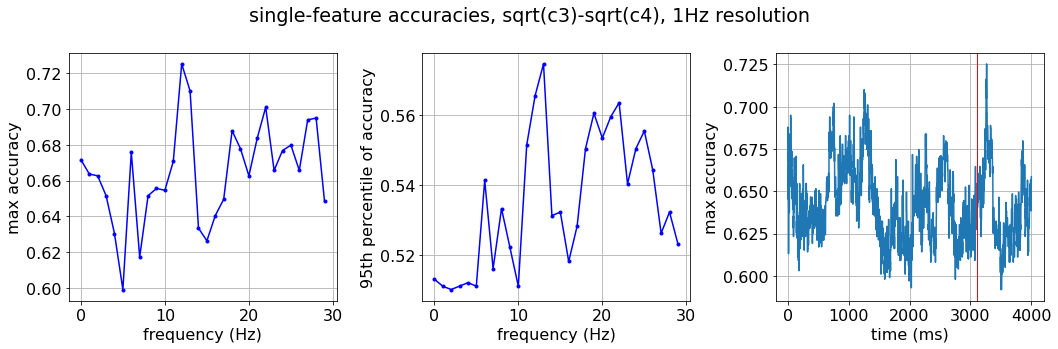

In [28]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(np.max(ACCS, axis=(0, 1)), 'b.-')
plt.grid()
plt.xlabel('frequency (Hz)')
plt.ylabel('max accuracy')

plt.subplot(1, 3, 2)
plt.plot(np.percentile(ACCS[:, 1000:4000, :], 95, axis=(0, 1)), 'b.-')
plt.grid()
plt.xlabel('frequency (Hz)')
plt.ylabel('95th percentile of accuracy')

plt.subplot(1, 3, 3)
plt.plot(np.max(ACCS, axis=(0, 2)))
plt.grid()
plt.xlabel('time (ms)')
plt.ylabel('max accuracy')
plt.plot(3100, 0.6, 'r|', ms=2000)

plt.suptitle('single-feature accuracies, sqrt(c3)-sqrt(c4), 1Hz resolution')
plt.tight_layout()

Text(0.5, 1.0, 'best frequency component at each time')

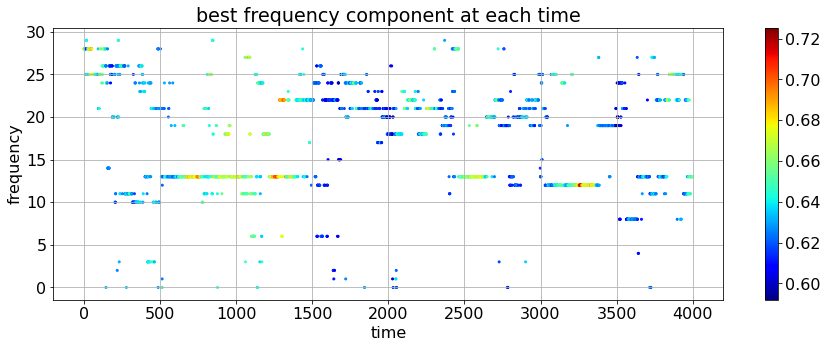

In [29]:
plt.figure(figsize=(15, 5))
plt.scatter(np.arange(4000), np.argmax(np.max(ACCS, axis=0), axis=1),
            cmap='jet', c=np.max(np.max(ACCS, axis=0), axis=1), s=4)
plt.grid()
plt.colorbar()
plt.xlabel('time')
plt.ylabel('frequency')
plt.title('best frequency component at each time')

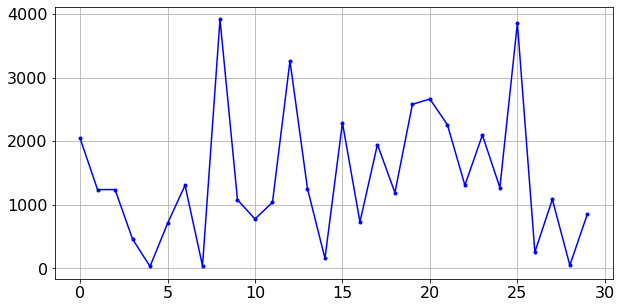

In [30]:
plt.figure(figsize=(10, 5))
plt.plot(np.argmax(np.max(ACCS, axis=0), axis=0), 'b.-')
plt.grid()

Text(0.5, 1.0, 'best accuracy at each time and frequency')

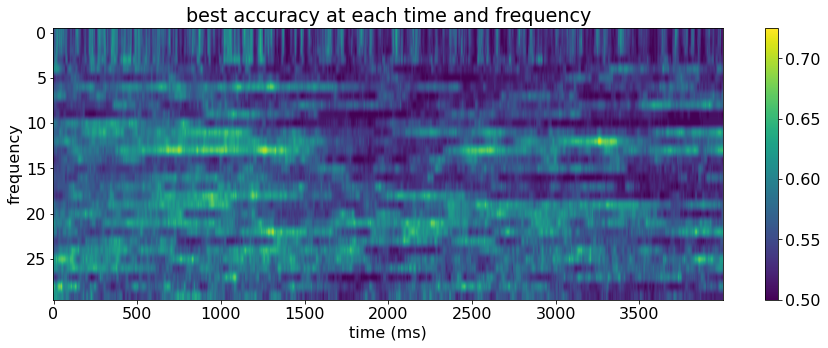

In [31]:
plt.figure(figsize=(15, 5))
ind = best_indices[0]
plt.imshow(np.max(ACCS, axis=0).T, aspect='auto')
plt.colorbar()
plt.xlabel('time (ms)')
plt.ylabel('frequency')
plt.title('best accuracy at each time and frequency')

In [32]:
# Mean(Sqrt(|power_c3|)) - Mean(Sqrt(|power_c4|))
#feature = np.mean(np.sqrt(np.abs(X_c3_spec[:, 1000, 13:14])), axis=1) - \
#    np.mean(np.sqrt(np.abs(X_c4_spec[:, 1000, 13:14])), axis=1)
feature = np.mean(np.sqrt(np.abs(X_c3_spec[:, 1500:3500, 13:14])), axis=(1, 2)) - \
    np.mean(np.sqrt(np.abs(X_c4_spec[:, 1500:3500, 13:14])), axis=(1, 2))
feature_L = feature[y==0]
feature_R = feature[y==1]
print(scipy.stats.ranksums(feature_L, feature_R))

data_feature = np.mean(np.sqrt(np.abs(c3_spec)[:, 13:14]), axis=1) - \
    np.mean(np.sqrt(np.abs(c4_spec)[:, 13:14]), axis=1)

RanksumsResult(statistic=2.7318195104797534, pvalue=0.006298563551684377)


In [33]:
mn = np.minimum(np.min(feature_L), np.min(feature_R))
mx = np.maximum(np.max(feature_L), np.max(feature_R))
thresholds = np.sort(feature)
roc = np.array(
    [[np.mean(feature_L < threshold), np.mean(feature_R < threshold)] for threshold in thresholds])

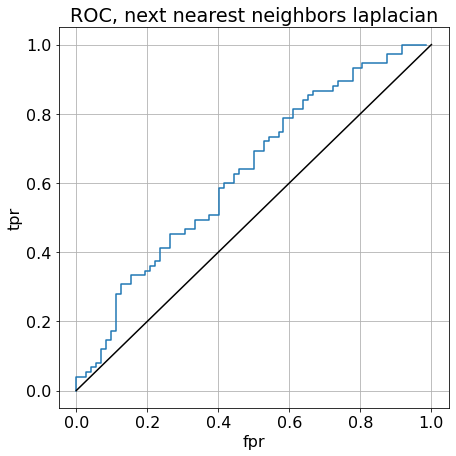

In [34]:
plt.figure(figsize=(7, 7))
plt.plot(roc[:, 0], roc[:, 1])
plt.plot([0, 1], [0, 1], 'k')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC, next nearest neighbors laplacian')
plt.grid()

0.6016666666666666 0.0002494296
acc at mean (red dot): 0.5586111111111112


Text(0.5, 1.0, 'balanced threshold-accuracy curve,\nnext nearest neighbors laplacian')

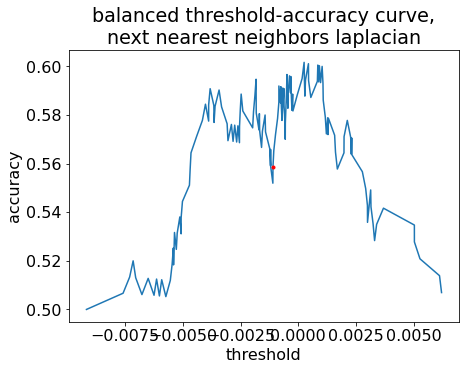

In [35]:
plt.figure(figsize=(7, 5))
accs = 0.5*((1-roc[:, 0]) + roc[:, 1])
plt.plot(thresholds, accs)
print(np.max(accs), thresholds[np.argmax(accs)])
acc_at_mean = accs[np.argmin(np.abs(thresholds - np.mean(data_feature)))]
print('acc at mean (red dot):', acc_at_mean)
plt.plot(np.mean(data_feature), acc_at_mean, 'r.')
plt.xlabel('threshold')
plt.ylabel('accuracy')
plt.title('balanced threshold-accuracy curve,\nnext nearest neighbors laplacian')

In [36]:
train_inds = np.arange(nTrain)
test_inds = np.arange(nTrain, N)

mn = np.min(feature)
mx = np.max(feature)
thresholds = np.sort(feature)
roc = np.array(
    [[np.mean(feature[train_inds][y[train_inds]==0] < threshold),
      np.mean(feature[train_inds][y[train_inds]==1] < threshold)] for threshold in thresholds])
accs = 0.5*((1-roc[:, 0]) + roc[:, 1])

threshold = thresholds[np.argmax(accs)]
pred = (feature < threshold)

In [37]:
print('train accuracy:', np.mean((y == pred)[train_inds]))
print('test accuracy:', np.mean((y == pred)[test_inds]))

train accuracy: 0.6
test accuracy: 0.5531914893617021


In [38]:
test_accs = []
thresholds = np.sort(feature)
for trial in range(1000):
    perm = np.random.permutation(N)
    train_inds = perm[0:nTrain]
    test_inds = perm[nTrain:None]
    roc = np.array(
        [[np.mean(feature[train_inds][y[train_inds]==0] < threshold),
          np.mean(feature[train_inds][y[train_inds]==1] < threshold)] for threshold in thresholds])
    accs = 0.5*((1-roc[:, 0]) + roc[:, 1])
    threshold = thresholds[np.argmax(accs)]
    pred = (feature < threshold)
    train_acc = np.mean((y == pred)[train_inds])
    test_acc = np.mean((y == pred)[test_inds])
    test_accs.append(test_acc)

0.5432765957446809 0.5531914893617021


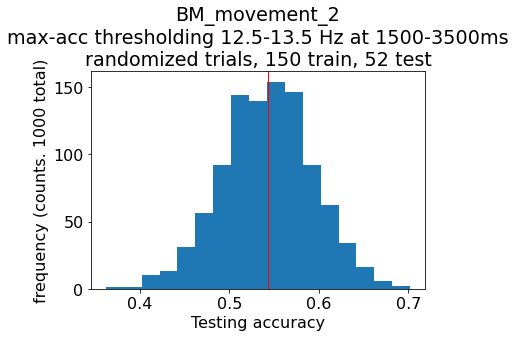

In [39]:
plt.hist(test_accs, bins=len(set(test_accs)))
plt.xlabel('Testing accuracy')
plt.ylabel('frequency (counts. 1000 total)')
plt.title('BM_movement_2\nmax-acc thresholding 12.5-13.5 Hz at 1500-3500ms\nrandomized trials, 150 train, 52 test')
print(np.mean(test_accs), np.median(test_accs))
plt.plot(np.mean(test_accs), 0, 'r|', ms=2000)

In [40]:
rand_accs = []
for trial in range(5000):
    perm = np.random.permutation(N)
    train_inds = perm[0:nTrain]
    test_inds = perm[nTrain:None]
    
    p = np.mean(y[train_inds])
    pred = (np.random.rand(N) < p).astype('int')
    rand_accs.append(np.mean(pred[test_inds]==y[test_inds]))

0.5432765957446809 0.5531914893617021


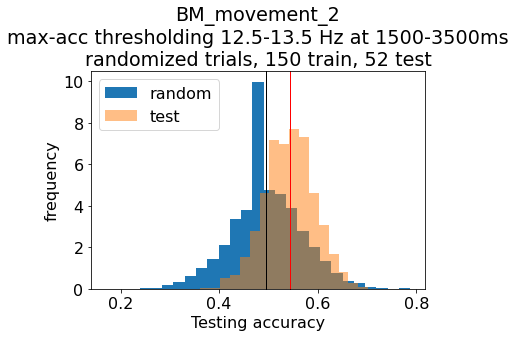

In [41]:
_ = plt.hist(rand_accs, bins=len(set(rand_accs)), density=True)
plt.hist(test_accs, bins=len(set(test_accs)), density=True, alpha=0.5)
plt.xlabel('Testing accuracy')
plt.ylabel('frequency')
plt.title('BM_movement_2\nmax-acc thresholding 12.5-13.5 Hz at 1500-3500ms\nrandomized trials, 150 train, 52 test')
print(np.mean(test_accs), np.median(test_accs))
plt.plot(np.mean(test_accs), 0, 'r|', ms=2000, label='_nolegend_')
plt.plot(np.mean(rand_accs), 0, 'k|', ms=2000, label='_nolegend_')
plt.legend(['random', 'test'])